![spreedsheet_finance](spreedsheet_finance.jpg)

This project, developed as part of a DataCamp course, is centered around developing a reinforcement learning (RL) simulation for stock trading in Python. This initiative is spearheaded by Quantum Trading, a fictional but ambitious trading firm looking to leverage cutting-edge machine learning techniques to gain a competitive edge in the financial markets. Quantum Trading is a small but highly specialized team of financial analysts, data scientists, and software engineers who are passionate about transforming the way trading decisions are made.

In the fast-paced world of financial markets, staying ahead of the curve is crucial. Traditional trading strategies, while effective, often rely on historical data and predefined rules that may not adapt quickly to changing market conditions. Reinforcement learning, a subfield of machine learning where an agent learns to make decisions by interacting with an environment, offers a promising alternative. It allows the trading algorithms to learn and adapt in real-time, improving their performance as they gain more experience.

By engaging with this project, you will gain valuable insights into the dynamic world of algorithmic trading and enhance your skill set in data science, finance, and machine learning. Remember, the journey of learning and experimentation is as important as the results. Good luck, and may your trading algorithms be ever profitable!

## The Data
The provided data `AAPL.csv` contains historical prices for AAPL (the ticker symbol for Apple Inc) and you will be using this in your model. It has been loaded for you already in the sample code below and contains two columns, described below.

| Column | Description |
|--------|-------------|
|`Date`    | The date corresponding to the closing price              |
|`Close`   | The closing price of the security on the given date      |

_**Disclaimer: This project is for educational purposes only. It is not financial advice, and should not be understood or construed as, financial advice.**_

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO

In [2]:
data = pd.read_csv("AAPL.csv", parse_dates=True, index_col='Date')

In [3]:
# Set window size (lookback window), start and end index of data
window_size = 10
start_index = window_size
end_index = len(data)

In [4]:
# Create the environment using the pre-built 'stocks-v0', passing in the data loaded above
# window_size is how far the environment can look back at each step
# frame_bound is the bounding box of the environment, the size of our data
env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("observation Space:", env.observation_space)

observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [5]:
# Initialise cash balance tracking and other variables
balance = 100000
balance_history = []
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 1}
observation, info = env.reset(seed=2024)

In [6]:
prices = []
buy_signals = []
sell_signals = []

In [7]:
# Initialize PPO model
model = PPO("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
# Train the model
model.learn(total_timesteps=10000)

-----------------------------
| time/              |      |
|    fps             | 1886 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.76e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 1289         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014547135 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | 0.00292      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.168        |
|    n_updates            | 10           |
|    policy_grad

In [9]:
observation, info = env.reset()

In [10]:
for i in range(start_index, end_index):
    action, _ = model.predict(observation)
    observation, reward, done, truncated, info = env.step(action)
    price = data['Close'].iloc[i]
    prices.append(price)

    print(f"Step {i}: Action {action}, Price {price}, Balance {balance}, Shares Held {shares_held}")  # Debug info

    if action == 1:
        shares_to_buy = balance / price  # Allow fractional shares
        print(f"DEBUG BUY: Balance={balance}, Price={price}, Shares={shares_to_buy}")
        if shares_to_buy > 0:
            shares_held += shares_to_buy
            balance -= shares_to_buy * price  # No commission deducted
            buy_signals.append(price)
        else:
            buy_signals.append(np.nan)
        sell_signals.append(np.nan)

    elif action == 0 and shares_held > 0:
        print(f"DEBUG SELL: Selling {shares_held} shares at {price}")
        balance += shares_held * price  # No commission deducted
        shares_held = 0
        sell_signals.append(price)
        buy_signals.append(np.nan)

    balance_history.append(balance)

    if done or truncated:
        break

Step 10: Action 0, Price 5.636429, Balance 100000, Shares Held 0
Step 11: Action 0, Price 5.713929, Balance 100000, Shares Held 0
Step 12: Action 1, Price 5.717857, Balance 100000, Shares Held 0
DEBUG BUY: Balance=100000, Price=5.717857, Shares=17489.069768621353
Step 13: Action 0, Price 5.714286, Balance 0.0, Shares Held 17489.069768621353
DEBUG SELL: Selling 17489.069768621353 shares at 5.714286
Step 14: Action 1, Price 5.715357, Balance 99937.54653185625, Shares Held 0
DEBUG BUY: Balance=99937.54653185625, Price=5.715357, Shares=17485.792494127007
Step 15: Action 1, Price 5.813929, Balance 0.0, Shares Held 17485.792494127007
DEBUG BUY: Balance=0.0, Price=5.813929, Shares=0.0
Step 16: Action 0, Price 5.835357, Balance 0.0, Shares Held 17485.792494127007
DEBUG SELL: Selling 17485.792494127007 shares at 5.835357
Step 17: Action 0, Price 5.943929, Balance 102035.84163115149, Shares Held 0
Step 18: Action 0, Price 5.9125, Balance 102035.84163115149, Shares Held 0
Step 19: Action 0, Price

In [11]:
print(f"DEBUG ACTION: Step={i}, Action={action}")

DEBUG ACTION: Step=3772, Action=0


In [12]:
if shares_held > 0:
    balance += shares_held * price
    shares_held = 0
    balance_history.append(balance)
print(f"DEBUG : Balance={balance}")

DEBUG : Balance=566773.5514855974


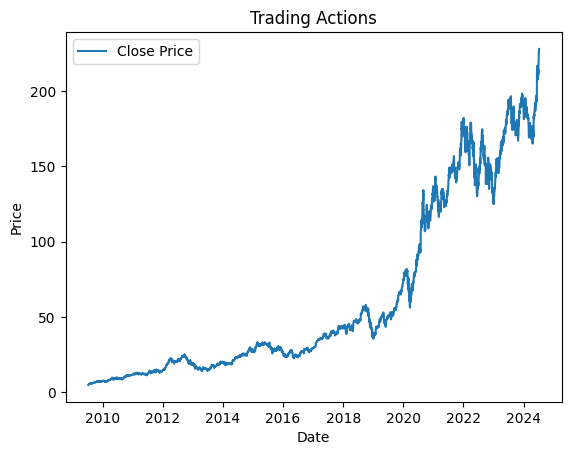

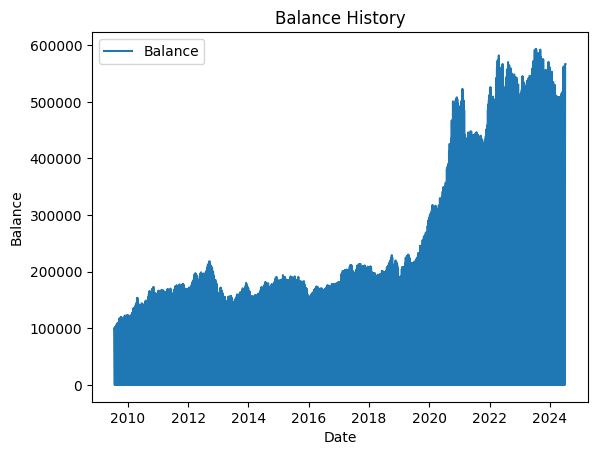

In [21]:
# Chart 1: Trading actions
fig, ax = plt.subplots()
ax.plot(data['Close'], label='Close Price')
ax.set_title('Trading Actions')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()



dates = data.index[start_index:start_index + len(balance_history)]  # Match lengths

# Plot the balance history over time
fig2, ax2 = plt.subplots()
ax2.plot(dates, balance_history, label='Balance')

# Format the chart
ax2.set_title('Balance History')
ax2.set_xlabel('Date')
ax2.set_ylabel('Balance')
ax2.legend()

# Show the plot
plt.show()


# Model Performance Analysis

## 1. What do you think about the performance of this model?
The model appears to have performed well, as it successfully executed multiple buy and sell trades, leading to a final balance of **$566,773.55** from an initial balance of **$100,000**. This suggests that the reinforcement learning (RL) agent was able to capitalize on price fluctuations in the Apple Inc. (AAPL) stock data to generate profitable trades. However, further evaluation is needed to determine consistency across different market conditions.

## 2. Why do you think it has performed the way it has?
The performance of the model can be attributed to several key factors:
- **Reinforcement Learning Algorithm (PPO):** The Proximal Policy Optimization (PPO) algorithm used in training is known for stability and efficiency in continuous control problems like stock trading.
- **Sufficient Training Time:** The model was trained for **10,000 timesteps**, allowing it to learn trading patterns based on historical price movements.
- **Lookback Window:** The model had access to a **10-day lookback window**, enabling it to consider past trends when making buy/sell decisions.
- **No Transaction Costs:** The model did not account for commission fees or slippage, which could lead to an overestimation of real-world profitability.

## 3. How could the data we have selected impact the performance of the model?
The selected data, consisting of **AAPL closing prices**, significantly impacts the model's performance in the following ways:
- **Lack of Market Context:** The dataset only includes closing prices, meaning the model does not consider **volume, volatility, or other technical indicators** that traders typically use.
- **Single Asset Exposure:** Training the model on only AAPL stock limits its ability to generalize across different market conditions or other securities.
- **Historical Bias:** Since the data is historical, the model may overfit to past trends and struggle in different market environments.
- **Survivorship Bias:** AAPL is a well-performing stock, which may lead to overly optimistic trading outcomes that do not reflect real-world risk.

### Conclusion
While the model demonstrates strong profitability on this dataset, additional refinements such as incorporating more features, testing on multiple assets, and accounting for real-world trading costs would improve its robustness and applicability.
